In [29]:
import boto3
import pyarrow.parquet as pq
from io import BytesIO

# Initialize Boto3 S3 client
s3_client = boto3.client('s3')

bucket_name = 'bpkbbucket'  # Replace with your S3 bucket name
parquet_folder = 'last_minute/'  # Updated folder path

# Function to read Parquet files from S3 bucket
def read_parquet_from_s3(bucket, folder, file_name):
    # Get Parquet file from S3
    response = s3_client.get_object(Bucket=bucket, Key=folder + file_name)
    # Read Parquet file using pyarrow
    parquet_file = pq.read_table(BytesIO(response['Body'].read()))
    return parquet_file

uuid = 'e291fb85-8f21-46c7-b840-d65b15e90ad8'
parquet_files = [f'part-{i:05d}-{uuid}-c000.snappy.parquet' for i in range(32)]

# Read Parquet files into a dictionary of PyArrow Tables with specific names
parquet_tables = {}
for i, file_name in enumerate(parquet_files):
    table_name = f'df{i+1}'
    table = read_parquet_from_s3(bucket_name, parquet_folder, file_name)
    parquet_tables[table_name] = table


In [30]:
import pyarrow as pa

# Initialize the list to hold all PyArrow Tables
all_tables = []

# Read Parquet files and append each table to the list
for file_name in parquet_files:
    table = read_parquet_from_s3(bucket_name, parquet_folder, file_name)
    all_tables.append(table)

# Combine all tables into one
combined_table = pa.concat_tables(all_tables)


In [31]:
import pyarrow as pa

# Assuming combined_table is your combined PyArrow Table from previous steps

# Convert the combined PyArrow Table to a Pandas DataFrame
combined_df = combined_table.to_pandas()

# Print the first few rows of the DataFrame
print(combined_df.head())


  pixel_color   x    y
0     #FFFFFF  41  487
1     #FFFFFF  -5  484
2     #FFFFFF  54  481
3     #FFFFFF  51  479
4     #FF4500 -86  497


In [32]:
combined_df.shape

(1766866, 3)

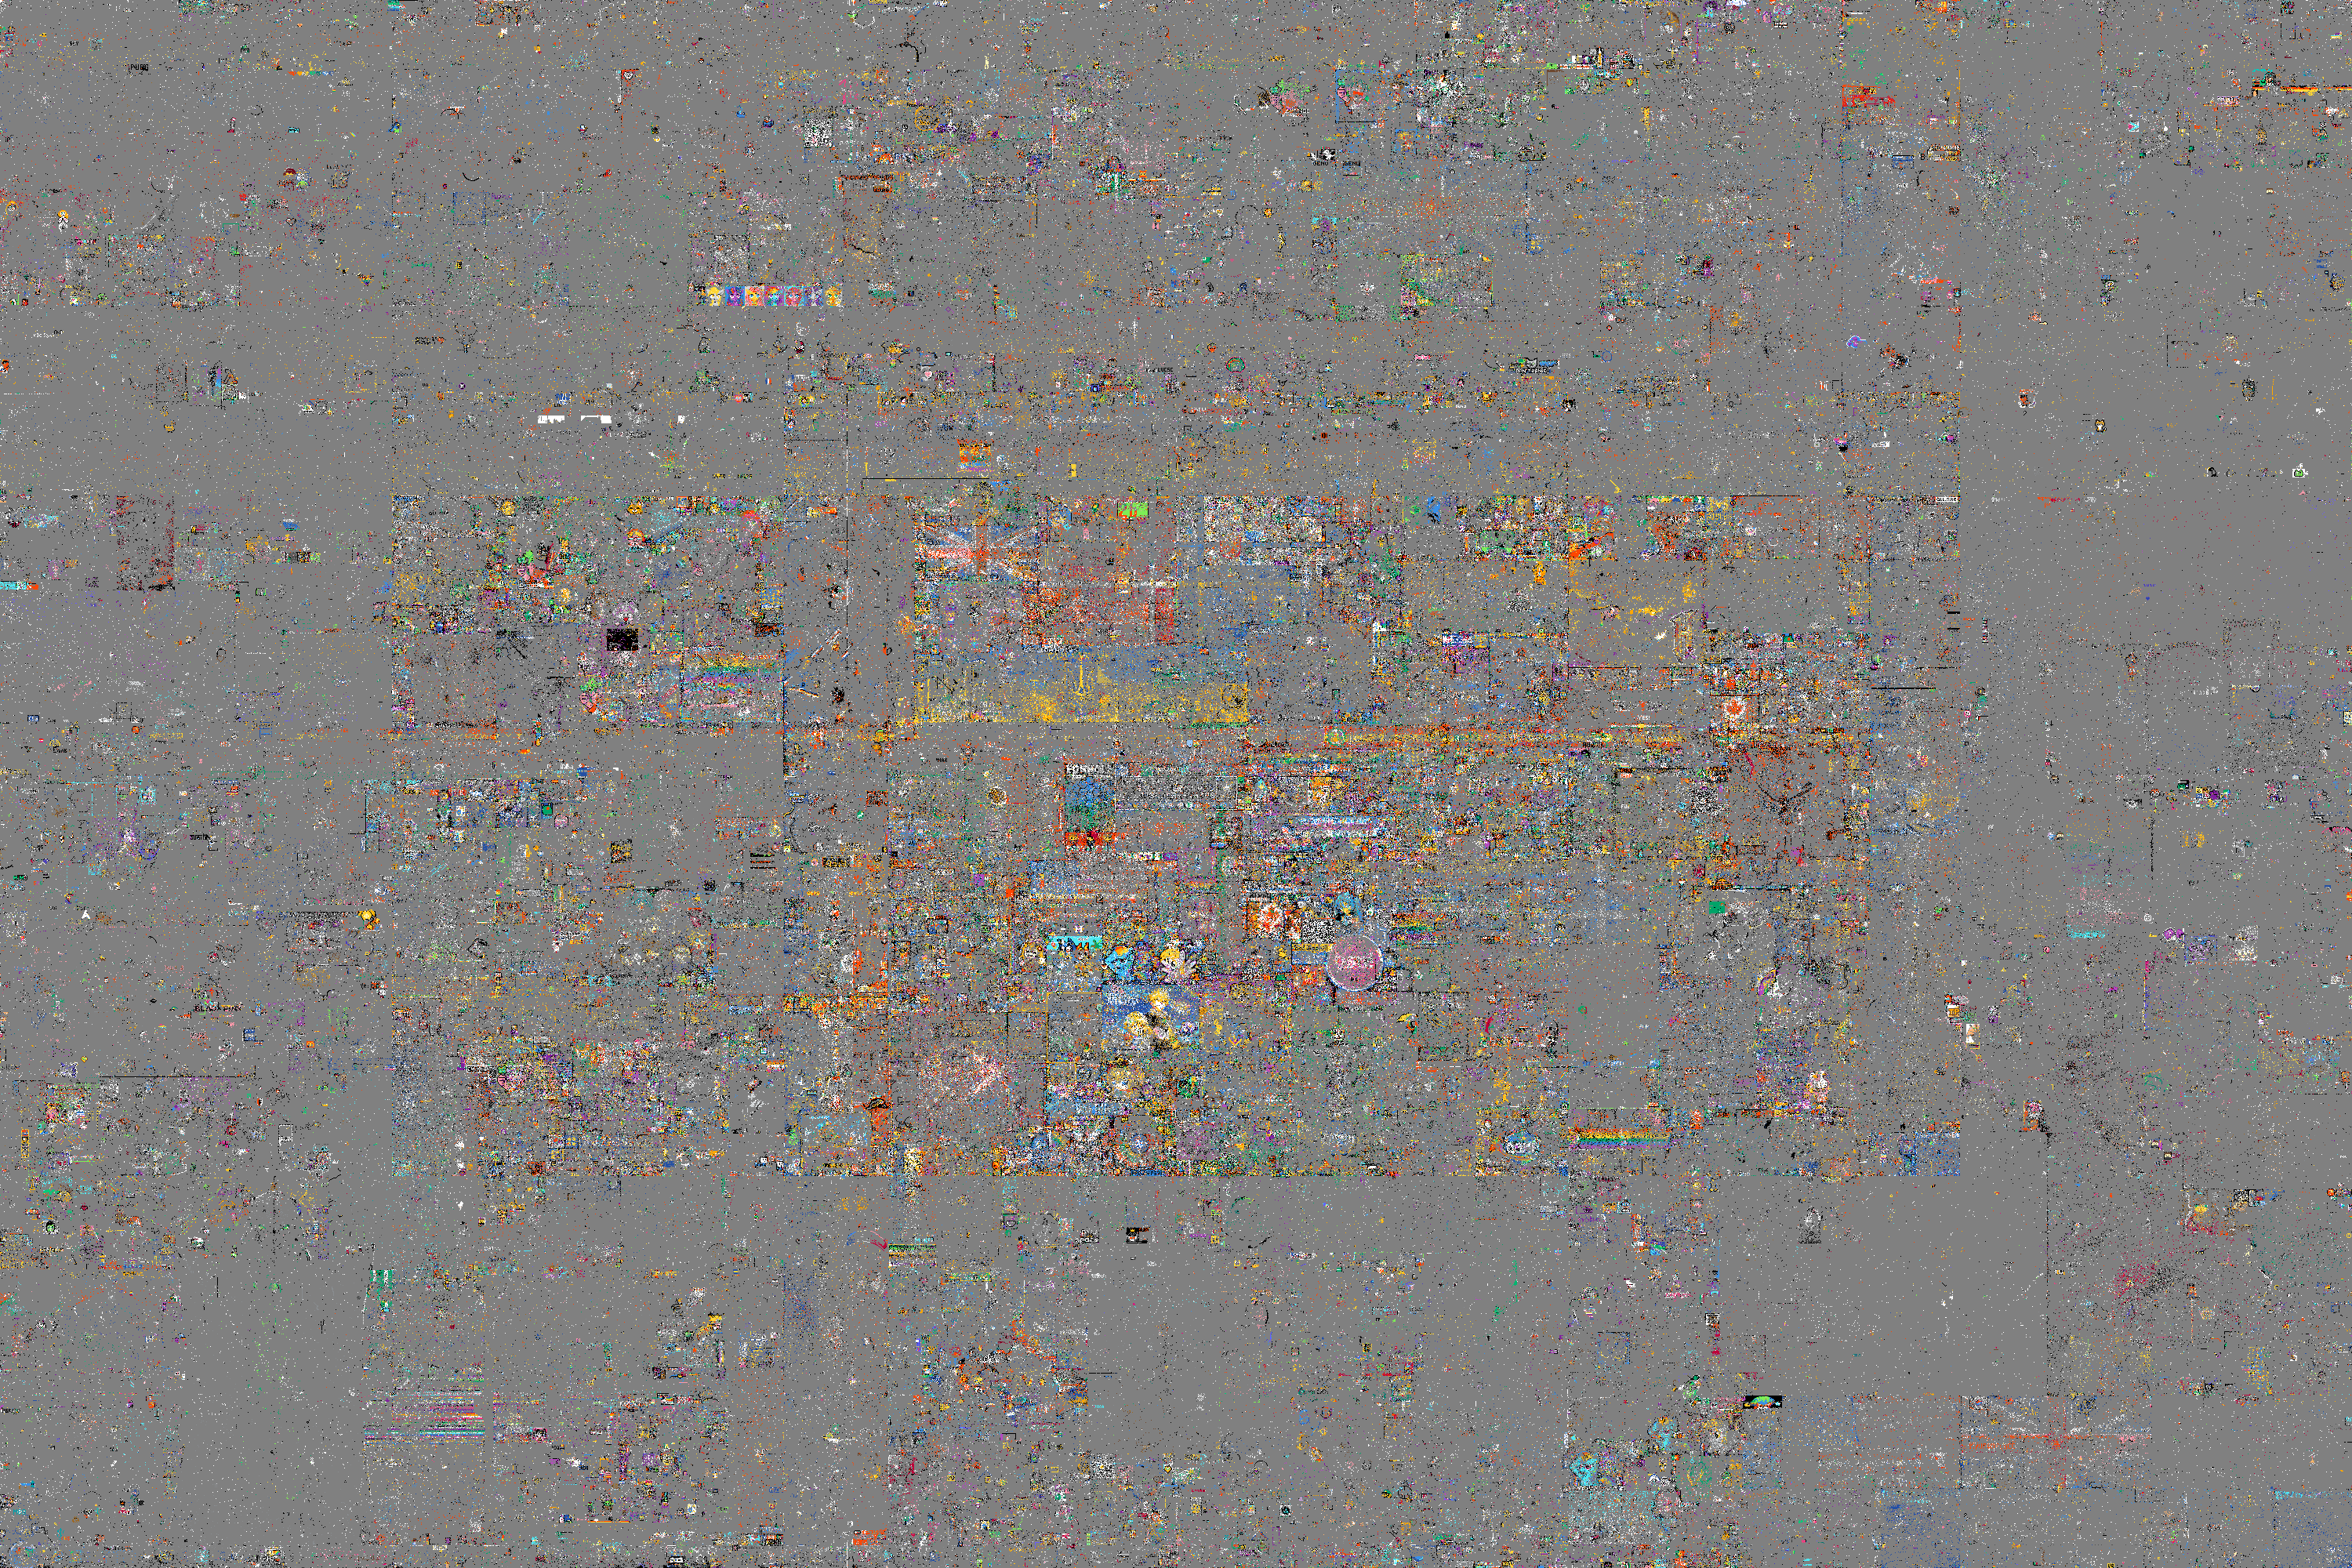

In [33]:
#Real
import pandas as pd
from PIL import Image, ImageDraw

# Assuming 'combined_df' is the DataFrame you've created from the combined PyArrow Table
df = combined_df

# Adjust the coordinates if necessary
df['x'] += 1500
df['y'] += 1000

# Initialize a blank canvas with a white background
canvas_width = 3000
canvas_height = 2000
canvas = Image.new('RGB', (canvas_width, canvas_height), 'gray')
draw = ImageDraw.Draw(canvas)

# Extract coordinates and colors as lists
coordinates = list(zip(df['x'], df['y']))
colors = df['pixel_color'].tolist()

# Use zip to iterate over coordinates and colors simultaneously
for (x, y), color in zip(coordinates, colors):
    draw.point((x, y), fill=color)

# Save the image
display(canvas)